# Sato-Tate-Distributions

In [1]:
#auto
from math import asin, log, sqrt
import matplotlib.pyplot as plt
import numpy as np

def line1(xmin,xmax):
    return line([(xmin,1),(xmax,1)], rgbcolor=(1,0,0))

def Xab(a,b):
    bb = (asin(b)/2r + b*sqrt(1r-b^2r)/2r)
    aa = (asin(a)/2r + a*sqrt(1r-a^2r)/2r)
    def X(T):
        return (asin(T)/2r + T*sqrt(1r-T^2r)/2r - aa)/(bb - aa)
    return X

In [34]:
import bisect

class SatoTate:
    def __init__(self, E):
        self._E = E
    def __repr__(self):
        return "Sato-Tate data for ..."
    def anlist(self, n):
        return self._E.anlist(n)
    def normalized_aplist(self, n):
        anlist = self.anlist(n)
        two = float(2)
        v = [float(anlist[p])/(two*sqrt(p)) for p in prime_range(n)]
        return v
    def sorted_aplist(self, n):
        v = self.normalized_aplist(n)
        v.sort()
        return v
    def YCab(self, Cmax, a=-1, b=1):
        v = self.sorted_aplist(Cmax)
        
        denom = bisect.bisect_right(v, float(b)) - bisect.bisect_left(v, float(a))
        try:
            normalize = float(1)/denom
        except:
            def Y(T):
                return 1.0r
            return Y
        start_pos = bisect.bisect_left(v, float(a))
        
        def Y(T):
            # find position that T would go in if it were inserted
            # in the sorted list v.
            n = bisect.bisect_right(v, float(T)) - start_pos
            return n * normalize
        return Y

    def xyplot(self, C, a=-1, b=1):
        """
        Return the quantile-quantile plot for given a,b, up to C.
        """
        Y = self.YCab(C,a=a,b=b)
        X = Xab(a=a,b=b)
        pX = plot(X, a, b, rgbcolor=(1,0,0))
        pY = plot(Y, a, b, rgbcolor=(0,0,1))
        return pX + pY
    
    def _qqplot(self, C, a=-1, b=1):#the parametric plot doesn't work like this nowadays
        """
        Return the quantile-quantile plot for given a,b, up to C.
        """
        Y = self.YCab(C,a=a,b=b)
        X = Xab(a=a,b=b)
        print(X)
        print(Y)
        #pl = parametric_plot((X, Y), a,b)
        ll = line([(0,0), (1.1,1.1)], rgbcolor=(1,0,0))
        #return pl+ll
        return ll
    
    def Delta(self, C, a, b, max_points=300):
        """
        Delta_{a}^{b} function:
        INPUT: C - cutoff
        a,b - evaluate over the interval (a,b)
        max_points - number of points used in numerical integral
        """
        key = (C,a,b,max_points)
        try:
            return self._delta[key]
        except AttributeError:
            self._delta = {}
        except KeyError:
            pass
        X = Xab(a,b)
        Y = self.YCab(C,a,b)
        def h(T):
            return (X(T) - Y(T))^2r
        
        val, err = integral_numerical(h, a, b, max_points=max_points, algorithm='qag', rule=1, eps_abs=1e-10, eps_rel=1e-10)
        
        self._delta[key] = (val, err)
        return val, err
    
    def plot_Delta(self, Cmax, plot_points=400, max_points=100, a=-1, b=1):
        v = [(x,self.Delta(x, a, b, max_points=max_points)[0]) for x in range(0, Cmax, int(Cmax/plot_points))]
        return line(v,rgbcolor=(0,0,0), ymin=0, ymax=0.1)
    
    def theta(self, C, a=-1, b=1, max_points=300):
        val, err = self.Delta(C, a, b, max_points=max_points)
        return -log(val)/log(C), val, err
    
    def theta_interval(self, C, a=-1, b=1, max_points=300):
        val, err = self.Delta(C, a, b, max_points=max_points)
        return -log(val-abs(err))/log(C), -log(val+abs(err))/log(C)
    
    def compute_theta(self, Cmax, plot_points=30, a=-1, b=1, max_points=300, verbose=False):
        a,b = (float(a), float(b))
        
        def f(C):
            z = self.theta(C, a, b, max_points=max_points)
            if verbose: print(C, z)
            return z[0]
        return [(x,f(x)) for x in range(100, Cmax, int(Cmax/plot_points))]
    
    def compute_theta_interval(self, Cmax, plot_points=30, a=-1, b=1, max_points=300, verbose=False):
        a,b = (float(a), float(b))
        vmin = []; vmax = []
        for C in range(100, Cmax, int(Cmax/plot_points)):
            zmin,zmax = self.theta_interval(C, a, b, max_points=max_points)
            vmin.append((C, zmin))
            vmax.append((C, zmax))
            if verbose: 
                print(C, zmin, zmax)
        return vmin, vmax
    
    def plot_theta_interval(self, Cmax, clr=(0,0,0), *args, **kwds):
        vmin, vmax = self.compute_theta_interval(Cmax, *args, **kwds)
        v = self.compute_theta(Cmax, *args, **kwds)
        grey = (0.7,0.7,0.7)
        return line(vmin,rgbcolor=grey)+line(vmax,rgbcolor=grey) + point(v,rgbcolor=clr) + line(v,rgbcolor=clr) + line1(0, Cmax)
    
    def plot_theta(self, Cmax, clr=(0,0,0), *args, **kwds):
        v = self.compute_theta(Cmax, *args, **kwds)
        return point(v,rgbcolor=clr, ymin=0, ymax=1.2) + line(v, rgbcolor=clr) + line1(0,Cmax)
        
    def histogram(self, Cmax, num_bins):
        '''
        modified with matplotlib plotting
        '''
        #original code:
        #v = self.normalized_aplist(Cmax)
        #d, total_number_of_points = dist(v, num_bins)
        #return frequency_histogram(d, num_bins, total_number_of_points) + semicircle
        v = self.normalized_aplist(Cmax)
        n, bins, patches = plt.hist(v, num_bins, density=True)
        angle = np.linspace(0, np.pi, 150) 
        radius = 1
        x = radius * np.cos(angle) 
        y = radius * np.sin(angle) * 2 / np.pi #stretching so that area = 1
        plt.plot(x, y)
        plt.xlabel('$a_p/\\sqrt{p}$')
        plt.ylabel('Frequency')
        plt.title('Sato-Tate-Distribution for E = {}'.format(self._E))
        #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
        plt.xlim(-1,1)
        #plt.ylim(0, 1)
        plt.grid(True)
        plt.show()
        
    def x_times_Delta(self, x):
        return x*self.Delta(x, -1,1, max_points=500)[0]

In [35]:
E1 = EllipticCurve([0, 0, 1, -1, 0]) # rank 1
E2 = EllipticCurve([0, 1, 1, -2, 0]) # rank 2
E3 = EllipticCurve([0, 0, 1, -7, 6]) # rank 3
E4 = EllipticCurve([1, -1, 0, -79, 289]) # rank 4
E5 = EllipticCurve([0, 0, 1, -79, 342]) # rank 5

S1 = SatoTate(E1)
S2 = SatoTate(E2)
S3 = SatoTate(E3)
S4 = SatoTate(E4)
S5 = SatoTate(E5)

objects = [S1, S2, S3, S4, S5]


#S.anlist(100)
#S.normalized_aplist(100)
#S.sorted_aplist(100)
#S.YCab(100)
#S.xyplot(1000)
#S.qqplot(100) #does not work because of parametric plot
#S.Delta(1000,-1,1)
#S.theta(1000)
#S.theta_interval(1000)
#S.compute_theta(1000)
#S.compute_theta_interval(1000)
#S.plot_theta_interval(1000)
#S1.histogram(int(10e4), 50)

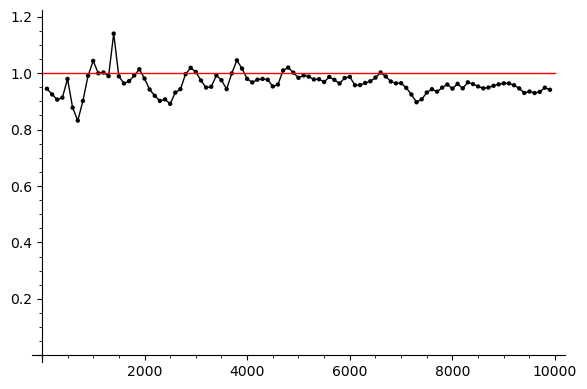

In [37]:
S1.plot_theta(10000,plot_points=100)

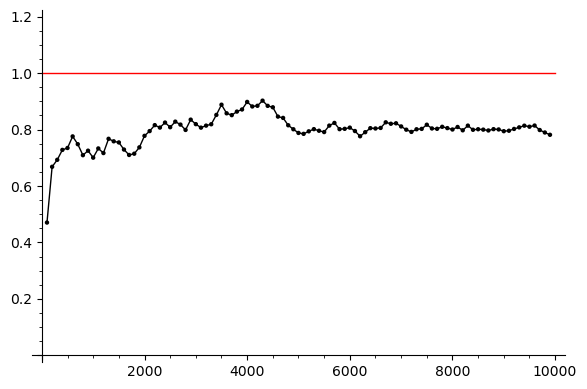

In [40]:
S2.plot_theta(10000,plot_points=100)

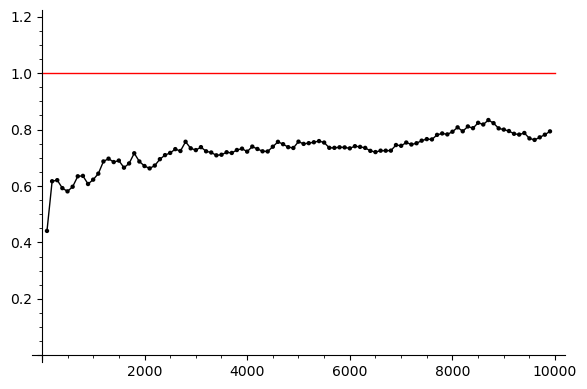

In [41]:
S3.plot_theta(10000,plot_points=100)

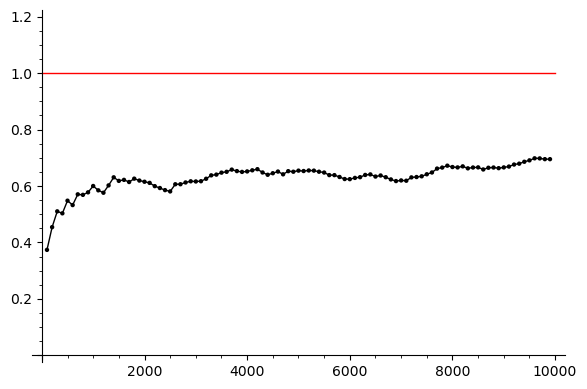

In [42]:
S4.plot_theta(10000,plot_points=100)

In [ ]:
S5.plot_theta(10000,plot_points=100)